# GPS vs Drone Telemetry Comparison

This notebook compares UBX GPS data with DJI drone telemetry data using the STOUT database integration. It provides interactive visualization of coordinate alignments, timestamps, and geographic positions.

## Cell 1: Import Required Libraries

In [689]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import importlib

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import polars as pl
from IPython.display import display, Image

# Add paths for imports
sys.path.insert(0, str(Path.cwd()))
sys.path.insert(0, str(Path("/home/stout")))
sys.path.insert(0, str(Path("/home/gabriele/Documents/data_loader")))

# Force complete reload of pils modules
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Import the StoutDataLoader - handles all data loading
from pils.loader import StoutDataLoader

print("✓ All libraries imported successfully")
print(f"✓ Reloaded {len(modules_to_remove)} pils modules")

✓ All libraries imported successfully
✓ Reloaded 23 pils modules


## Cell 2: Define All Helper Functions

In [526]:
def compare_coordinates(gps_df, drone_df, source_type='dat'):
    """Compare GPS coordinates between UBX and drone telemetry using time-based matching.
    
    Args:
        gps_df: GPS dataframe
        drone_df: Drone dataframe
        source_type: 'dat' or 'csv' - determines column name format
    """
    comparison = {}
    
    # Define column names based on source type
    if source_type == 'csv':
        lat_col = "GPS:Lat[degrees]"
        lat_col = "RTKdata:Lat_P"
        lon_col = "GPS:Long[degrees]"
        lon_col = "RTKdata:Lon_P"
    else:  # dat
        lat_col = "GPS:latitude"
        lon_col = "GPS:longitude"
    
    # Ensure both dataframes have timestamp column
    if "timestamp" not in gps_df.columns or "timestamp" not in drone_df.columns:
        print("Warning: timestamp column missing in one or both dataframes")
        return comparison
    
    # Sort both dataframes by timestamp
    gps_df = gps_df.sort("timestamp")
    drone_df = drone_df.sort("timestamp")
    
    # Find common time range
    gps_time_min = gps_df["timestamp"].min()
    gps_time_max = gps_df["timestamp"].max()
    drone_time_min = drone_df["timestamp"].min()
    drone_time_max = drone_df["timestamp"].max()
    
    common_time_min = max(gps_time_min, drone_time_min)
    common_time_max = min(gps_time_max, drone_time_max)
    
    # Filter to common time range
    gps_filtered = gps_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )
    drone_filtered = drone_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )
    
    # Interpolate drone data to GPS timestamps using join_asof
    # This performs a time-based join with nearest match
    if "posllh_lat" in gps_filtered.columns and lat_col in drone_filtered.columns:
        merged = gps_filtered.join_asof(
            drone_filtered.select(["timestamp", lat_col, lon_col]),
            on="timestamp",
            strategy="nearest"
        )
        
        if len(merged) > 0:
            # Latitude comparison
            gps_lats = merged["posllh_lat"].to_numpy()
            drone_lats = merged[lat_col].to_numpy()
            lat_diff = gps_lats - drone_lats
            
            comparison["latitude"] = {
                "mean_diff": float(np.mean(lat_diff)),
                "std_diff": float(np.std(lat_diff)),
                "max_diff": float(np.max(np.abs(lat_diff))),
                "samples": len(lat_diff)
            }
            
            # Longitude comparison
            if "posllh_lon" in merged.columns and lon_col in merged.columns:
                gps_lons = merged["posllh_lon"].to_numpy()
                drone_lons = merged[lon_col].to_numpy()
                lon_diff = gps_lons - drone_lons
                
                comparison["longitude"] = {
                    "mean_diff": float(np.mean(lon_diff)),
                    "std_diff": float(np.std(lon_diff)),
                    "max_diff": float(np.max(np.abs(lon_diff))),
                    "samples": len(lon_diff)
                }
                
                # Distance calculation (haversine)
                R = 6371000  # Earth radius in meters
                dlat = np.radians(drone_lats - gps_lats)
                dlon = np.radians(drone_lons - gps_lons)
                a = np.sin(dlat/2)**2 + np.cos(np.radians(gps_lats)) * np.cos(np.radians(drone_lats)) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))
                distances = R * c
                
                comparison["distance_m"] = {
                    "mean": float(np.mean(distances)),
                    "std": float(np.std(distances)),
                    "max": float(np.max(distances)),
                    "samples": len(distances)
                }
    
    comparison["time_range"] = {
        "common_start": float(common_time_min),
        "common_end": float(common_time_max),
        "duration_s": float(common_time_max - common_time_min)
    }
    
    return comparison


def plot_three_way_comparison(gps_df: pl.DataFrame, drone_sources: dict):
    """Create comparison plots showing RAW GPS vs drone sources - no time matching."""
    # Sort GPS data
    gps_df = gps_df.sort("timestamp")
    
    # Find global common time range across all sources
    gps_time_min = gps_df["timestamp"].min()
    gps_time_max = gps_df["timestamp"].max()
    
    common_time_min = gps_time_min
    common_time_max = gps_time_max
    
    for drone_df in drone_sources.values():
        drone_time_max = drone_df["correct_timestamp"].filter(drone_df["correct_timestamp"].is_not_nan()).max()
        drone_time_min = drone_df["correct_timestamp"].filter(drone_df["correct_timestamp"].is_not_nan()).min()
        print("#######")
        print("Time")
        print(gps_time_min, gps_time_max, drone_time_min, drone_time_max)
        common_time_min = max(common_time_min, drone_time_min)
        common_time_max = min(common_time_max, drone_time_max)
    
    

    # Filter GPS to common range
    gps_filtered = gps_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )

    print(gps_filtered)
    
    # Filter drone data to common range (NO JOIN - just filter by time)
    drone_filtered = {}
    for source_name, drone_df in drone_sources.items():
        drone_df = drone_df.sort("correct_timestamp")
        drone_filtered[source_name] = drone_df.filter(
            (pl.col("correct_timestamp") >= common_time_min) & 
            (pl.col("correct_timestamp") <= common_time_max)
        )
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('GPS vs DAT vs CSV - RAW Data (No Time Matching)', fontsize=16, fontweight='bold')
    
    colors = {'dat': 'blue', 'csv': 'orange'}
    
    # Plot 1: Latitude comparison - all three sources RAW
    ax = axes[0, 0]
    gps_times = gps_filtered["timestamp"].to_numpy()
    ax.plot(gps_times, gps_filtered["posllh_lat"].to_numpy(), '-', label="GPS", alpha=0.8, linewidth=1.5, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
        else:
            lat_col = "GPS:latitude"
        
        drone_times = drone_df["correct_timestamp"].to_numpy()
        drone_lats = drone_df[lat_col].to_numpy()
        ax.plot(drone_times, drone_lats, '-o', markersize=1,
                label=f"Drone {source_name.upper()}", alpha=0.7, linewidth=1, color=colors.get(source_name, 'red'))
    ax.set_title("Latitude Comparison (RAW)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Latitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Longitude comparison - all three sources RAW
    ax = axes[0, 1]
    ax.plot(gps_times, gps_filtered["posllh_lon"].to_numpy(), '-', label="GPS", alpha=0.8, linewidth=1.5, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lon_col = "GPS:Long[degrees]"
        else:
            lon_col = "GPS:longitude"
        
        drone_times = drone_df["correct_timestamp"].to_numpy()
        drone_lons = drone_df[lon_col].to_numpy()
        ax.plot(drone_times, drone_lons, '-o', markersize=1, 
                label=f"Drone {source_name.upper()}", alpha=0.7, linewidth=1, color=colors.get(source_name, 'red'))
    ax.set_title("Longitude Comparison (RAW)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Longitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Sample counts over time
    ax = axes[0, 2]
    ax.hist([gps_times], bins=50, alpha=0.6, label="GPS", color='green')
    for source_name, drone_df in drone_filtered.items():
        drone_times = drone_df["correct_timestamp"].to_numpy()
        ax.hist([drone_times], bins=50, alpha=0.5, label=f"Drone {source_name.upper()}", 
                color=colors.get(source_name, 'red'))
    ax.set_title("Sample Distribution Over Time")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Sample Count per Bin")
    ax.legend()
    ax.grid(True, alpha=0.3)


    # Plot 4: Geographic scatter - all three sources RAW
    ax = axes[1, 0]
    gps_lons = gps_filtered["posllh_lon"].to_numpy()
    gps_lats = gps_filtered["posllh_lat"].to_numpy()
    ax.scatter(gps_lons, gps_lats, label="GPS", alpha=0.6, s=10, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
            lon_col = "GPS:Long[degrees]"
        else:
            lat_col = "GPS:latitude"
            lon_col = "GPS:longitude"
        
        drone_lats = drone_df[lat_col].to_numpy()
        drone_lons = drone_df[lon_col].to_numpy()
        ax.scatter(drone_lons, drone_lats, 
                   label=f"Drone {source_name.upper()}", alpha=0.5, s=8, color=colors.get(source_name, 'red'))
    ax.set_title("Geographic Position (RAW)")
    ax.set_xlabel("Longitude [degrees]")
    ax.set_ylabel("Latitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 5: Sampling rate comparison
    ax = axes[1, 1]
    sample_counts = [len(gps_filtered)]
    labels = ['GPS']
    colors_list = ['green']
    for source_name, drone_df in drone_filtered.items():
        sample_counts.append(len(drone_df))
        labels.append(f'Drone {source_name.upper()}')
        colors_list.append(colors.get(source_name, 'red'))
    
    ax.bar(labels, sample_counts, color=colors_list, alpha=0.7)
    ax.set_title("Sample Counts")
    ax.set_ylabel("Number of Samples")
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, (label, count) in enumerate(zip(labels, sample_counts)):
        ax.text(i, count, str(count), ha='center', va='bottom')

    # Plot 6: Time coverage
    ax = axes[1, 2]
    ax.barh(['GPS'], [gps_time_max - gps_time_min], left=[gps_time_min - common_time_min], 
            color='green', alpha=0.7, label='GPS')
    offset = 0.3
    for i, (source_name, drone_df) in enumerate(drone_filtered.items()):
        drone_time_min = drone_df["correct_timestamp"].min()
        drone_time_max = drone_df["correct_timestamp"].max()
        ax.barh([f'Drone {source_name.upper()}'], [drone_time_max - drone_time_min], 
                left=[drone_time_min - common_time_min],
                color=colors.get(source_name, 'red'), alpha=0.7)
    ax.set_title("Time Coverage")
    ax.set_xlabel("Time [s] (relative to start)")
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()
    return fig


print("✓ All functions defined successfully")

✓ All functions defined successfully


## Cell 3: Configure and Load Flight Data

In [690]:
# Configuration - modify these values to analyze different flights
FLIGHT_UUID = "e809e9fe-0dcb-4a70-8300-ac9dceb99d3f"  # Flight from 2025-12-01 15:15
CSV_DRONE_FILE = "/home/gabriele/Documents/data_loader/data_1515.csv"  # Direct CSV file

# Initialize the StoutDataLoader
loader = StoutDataLoader(use_stout=True)
print('OK')
print("=" * 80)
print("AVAILABLE DATA TYPES")
print("=" * 80)
print(f"Sensors: {loader.get_available_sensors()}")
print(f"Drones: {loader.get_available_drones()}")
print()

print("=" * 80)
print("LOADING FLIGHT DATA")
print("=" * 80)

# Load GPS and DJI drone data using the generic loader
data = loader.load_flight_data(
    flight_id=FLIGHT_UUID,
    sensors=['gps'],
    drones=['dji'],
    drone_correct_timestamp=True
)

# Extract data from the loader result
flight_info = data['flight_info']
gps_df = data['gps']
drone_df = data['dji']

from pathlib import Path
from pils.drones.DJIDrone import DJIDrone

csv_path = Path(CSV_DRONE_FILE)
if csv_path.exists():
    # Use DJIDrone class to load CSV file
    drone_csv = DJIDrone(CSV_DRONE_FILE)
    drone_csv.load_data(use_dat=False, cols=None)  # Explicitly use CSV loading
    
    # Extract the CSV data from the dictionary
    if isinstance(drone_csv.data, pl.DataFrame):
        drone_csv_df = drone_csv.data
        print(f"✓ CSV drone data loaded: {drone_csv_df.shape}")
    else:
        drone_csv_df = None
        print("✗ CSV data not found in DJIDrone data dictionary")
else:
    drone_csv_df = None
    print(f"✗ CSV file not found: {CSV_DRONE_FILE}")

print()
print("FLIGHT INFORMATION")
print("=" * 80)
print(f"Flight Name: {flight_info.get('flight_name')}")
print(f"Takeoff: {flight_info.get('takeoff_datetime')}")
print(f"Landing: {flight_info.get('landing_datetime')}")
print(f"Flight Type: {flight_info.get('flight_type')}")
print()

print("DATA LOADED")
print("=" * 80)
print(f"✓ GPS data shape: {gps_df.shape if gps_df is not None else 'None'}")
print(f"✓ Drone DAT data shape: {drone_df.shape if drone_df is not None else 'None'}")
print(f"✓ Drone CSV data shape: {drone_csv_df.shape if drone_csv_df is not None else 'None'}")
print()

2026-01-28 13:55:54,445 - pils.loader - INFO - Initialized with stout database, base path: /mnt/data/POLOCALC
2026-01-28 13:55:54,446 - pils.loader - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-01-28 13:55:54,447 - pils.loader - INFO - Loaded flight: flight_20251201_1515
2026-01-28 13:55:54,447 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux
2026-01-28 13:55:54,448 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux/sensors/20251201_151517_GPS.bin


OK
AVAILABLE DATA TYPES
Sensors: ['gps', 'imu', 'adc', 'camera', 'inclinometer']
Drones: ['dji', 'litchi', 'blacksquare']

LOADING FLIGHT DATA


2026-01-28 13:55:57,070 - pils.loader - INFO - Loaded gps data: (1439, 21)
2026-01-28 13:55:57,071 - pils.loader - INFO - Loading dji data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/drone/20251201_151517_drone.dat
2026-01-28 13:56:00,922 - pils.drones.DJIDrone - INFO - Tick unwrap at index 4009: 4,294,296,476 -> 206,394 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-28 13:56:00,923 - pils.drones.DJIDrone - INFO - Loaded 7114 GPS messages from DAT file
2026-01-28 13:56:00,932 - pils.drones.DJIDrone - INFO - Tick unwrap at index 3705: 4,294,110,891 -> 43,735 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-28 13:56:00,933 - pils.drones.DJIDrone - INFO - Loaded 6625 RTK messages from DAT file
2026-01-28 13:56:01,035 - pils.drones.DJIDrone - INFO - Converting timestamps to milliseconds
2026-01-28 13:56:01,044 - pils.loader - INFO - Loaded dji data: OK
2026-01-28 13:56:01,213 - pils.drones.DJIDrone - INFO - Converting timestamps to millisecon

✓ CSV drone data loaded: (15736, 460)

FLIGHT INFORMATION
Flight Name: flight_20251201_1515
Takeoff: 2025-12-01 15:15:00
Landing: 2025-12-01 15:26:00
Flight Type: Beam/Pol. Angle

DATA LOADED
✓ GPS data shape: (1439, 21)
✓ Drone DAT data shape: (13608, 43)
✓ Drone CSV data shape: (15736, 460)



In [691]:
data

{'flight_info': {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x738a3d6925d0>,
  'flight_id': 'e809e9fe-0dcb-4a70-8300-ac9dceb99d3f',
  'so_obs_id': {'SATp1': '', 'SATp2': '', 'SATp3': ''},
  'campaign_id': '452f34cb-ba43-40a2-92a8-5773bf4d68cc',
  'class_obs_id': 'Not Available',
  'drone_id': 'b0678c3f-73ae-46ee-819f-e0d3ba0917a7',
  'drone_data_folder_path': '/mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/drone',
  'takeoff_datetime': datetime.datetime(2025, 12, 1, 15, 15),
  'aux_data_folder_path': '/mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux',
  'landing_datetime': datetime.datetime(2025, 12, 1, 15, 26),
  'processed_data_folder_path': '/mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/proc',
  'flight_type': 'Beam/Pol. Angle',
  'created_at': datetime.datetime(2025, 12, 2, 17, 17, 41, 441784),
  'flight_name': 'flight_20251201_1515',
  'updated_at': datetime.datetime(2025, 12, 19, 16, 33, 30, 376147),
  

In [528]:
# Prepare both drone data sources for comparison
print("=" * 80)
print("PREPARING DRONE DATA FOR COMPARISON")
print("=" * 80)

# Create a dictionary to hold all available drone data sources
drone_sources = {}

if drone_df is not None:
    drone_sources['dat'] = drone_df
    print(f"✓ DAT drone data available: {drone_df.shape}")
    
if drone_csv_df is not None:
    drone_sources['csv'] = drone_csv_df
    print(f"✓ CSV drone data available: {drone_csv_df.shape}")

if not drone_sources:
    print("✗ No drone data available!")
else:
    print(f"\nTotal drone sources available: {len(drone_sources)}")
    for source_name, df in drone_sources.items():
        print(f"  - {source_name.upper()}: {df.shape[0]} samples, {df.shape[1]} features")

PREPARING DRONE DATA FOR COMPARISON
✓ DAT drone data available: (13608, 44)
✓ CSV drone data available: (15736, 460)

Total drone sources available: 2
  - DAT: 13608 samples, 44 features
  - CSV: 15736 samples, 460 features


In [529]:
data['dji']["correct_timestamp"].min(), data['dji']["correct_timestamp"].max()

(1764601158.3337598, 1764602856.2145646)

## Cell 4: Data Summary and Exploration

## Cell 5: Compare GPS Coordinates

In [530]:
# Run comparison for ALL available drone data sources
print("=" * 80)
print("GPS VS DRONE COMPARISON - ALL SOURCES")
print("=" * 80)

comparisons = {}
for source_name, drone_data in drone_sources.items():
    print(f"\n{'=' * 80}")
    print(f"COMPARING GPS vs {source_name.upper()} DRONE DATA")
    print(f"{'=' * 80}")
    
    # Pass source_type to handle different column names
    comparison = compare_coordinates(gps_df, drone_data, source_type=source_name)
    comparisons[source_name] = comparison
    
    for key, stats in comparison.items():
        print(f"\n{key.upper()}:")
        for stat_name, stat_value in stats.items():
            print(f"  {stat_name}: {stat_value:.6f}")

# Summary comparison between sources
if len(comparisons) > 1:
    print("\n" + "=" * 80)
    print("COMPARISON SUMMARY: DAT vs CSV")
    print("=" * 80)
    
    for metric in ["latitude", "longitude", "distance_m"]:
        if all(metric in comp for comp in comparisons.values()):
            print(f"\n{metric.upper()}:")
            for source_name, comp in comparisons.items():
                if "mean" in comp[metric]:
                    print(f"  {source_name.upper()} - Mean: {comp[metric]['mean']:.2f}, Std: {comp[metric]['std']:.2f}")
                else:
                    print(f"  {source_name.upper()} - Mean diff: {comp[metric]['mean_diff']:.6f}°, Std: {comp[metric]['std_diff']:.6f}°")

GPS VS DRONE COMPARISON - ALL SOURCES

COMPARING GPS vs DAT DRONE DATA

LATITUDE:
  mean_diff: -0.000001
  std_diff: 0.000020
  max_diff: 0.000134
  samples: 1439.000000

LONGITUDE:
  mean_diff: 0.000008
  std_diff: 0.000013
  max_diff: 0.000082
  samples: 1439.000000

DISTANCE_M:
  mean: 2.079756
  std: 1.703985
  max: 15.727901
  samples: 1439.000000

TIME_RANGE:
  common_start: 1764602059.000000
  common_end: 1764602778.000000
  duration_s: 719.000000

COMPARING GPS vs CSV DRONE DATA

LATITUDE:
  mean_diff: -0.000000
  std_diff: 0.000032
  max_diff: 0.000135
  samples: 1403.000000

LONGITUDE:
  mean_diff: -0.000015
  std_diff: 0.000020
  max_diff: 0.000122
  samples: 1403.000000

DISTANCE_M:
  mean: 3.328215
  std: 2.792221
  max: 16.642865
  samples: 1403.000000

TIME_RANGE:
  common_start: 1764602059.000000
  common_end: 1764602760.000000
  duration_s: 701.000000

COMPARISON SUMMARY: DAT vs CSV

LATITUDE:
  DAT - Mean diff: -0.000001°, Std: 0.000020°
  CSV - Mean diff: -0.000000°,

## Cell 6: Generate 6-Panel Comparison Plots


THREE-WAY COMPARISON: GPS vs DAT vs CSV
#######
Time
1764602059.0 1764602778.0 1764601158.3337598 1764602856.2145646
#######
Time
1764602059.0 1764602778.0 1764601136.8461602 1764602759.7141602
shape: (1_402, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ unix_time ┆ posecef_e ┆ posecef_e ┆ posecef_e ┆ … ┆ clock_msg ┆ clock_tAc ┆ datetime  ┆ timestam │
│ _ms       ┆ cefX      ┆ cefY      ┆ cefZ      ┆   ┆ mode      ┆ c         ┆ ---       ┆ p        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ datetime[ ┆ ---      │
│ i64       ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ ms]       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 176460205 ┆ 222317927 ┆ -54441861 ┆ -24746360 ┆ … ┆ 0         ┆ 11        ┆ 2025-12-0 ┆ 1.7646e9 │
│ 9000      ┆           ┆ 6         ┆ 1         ┆   ┆           ┆           ┆ 1

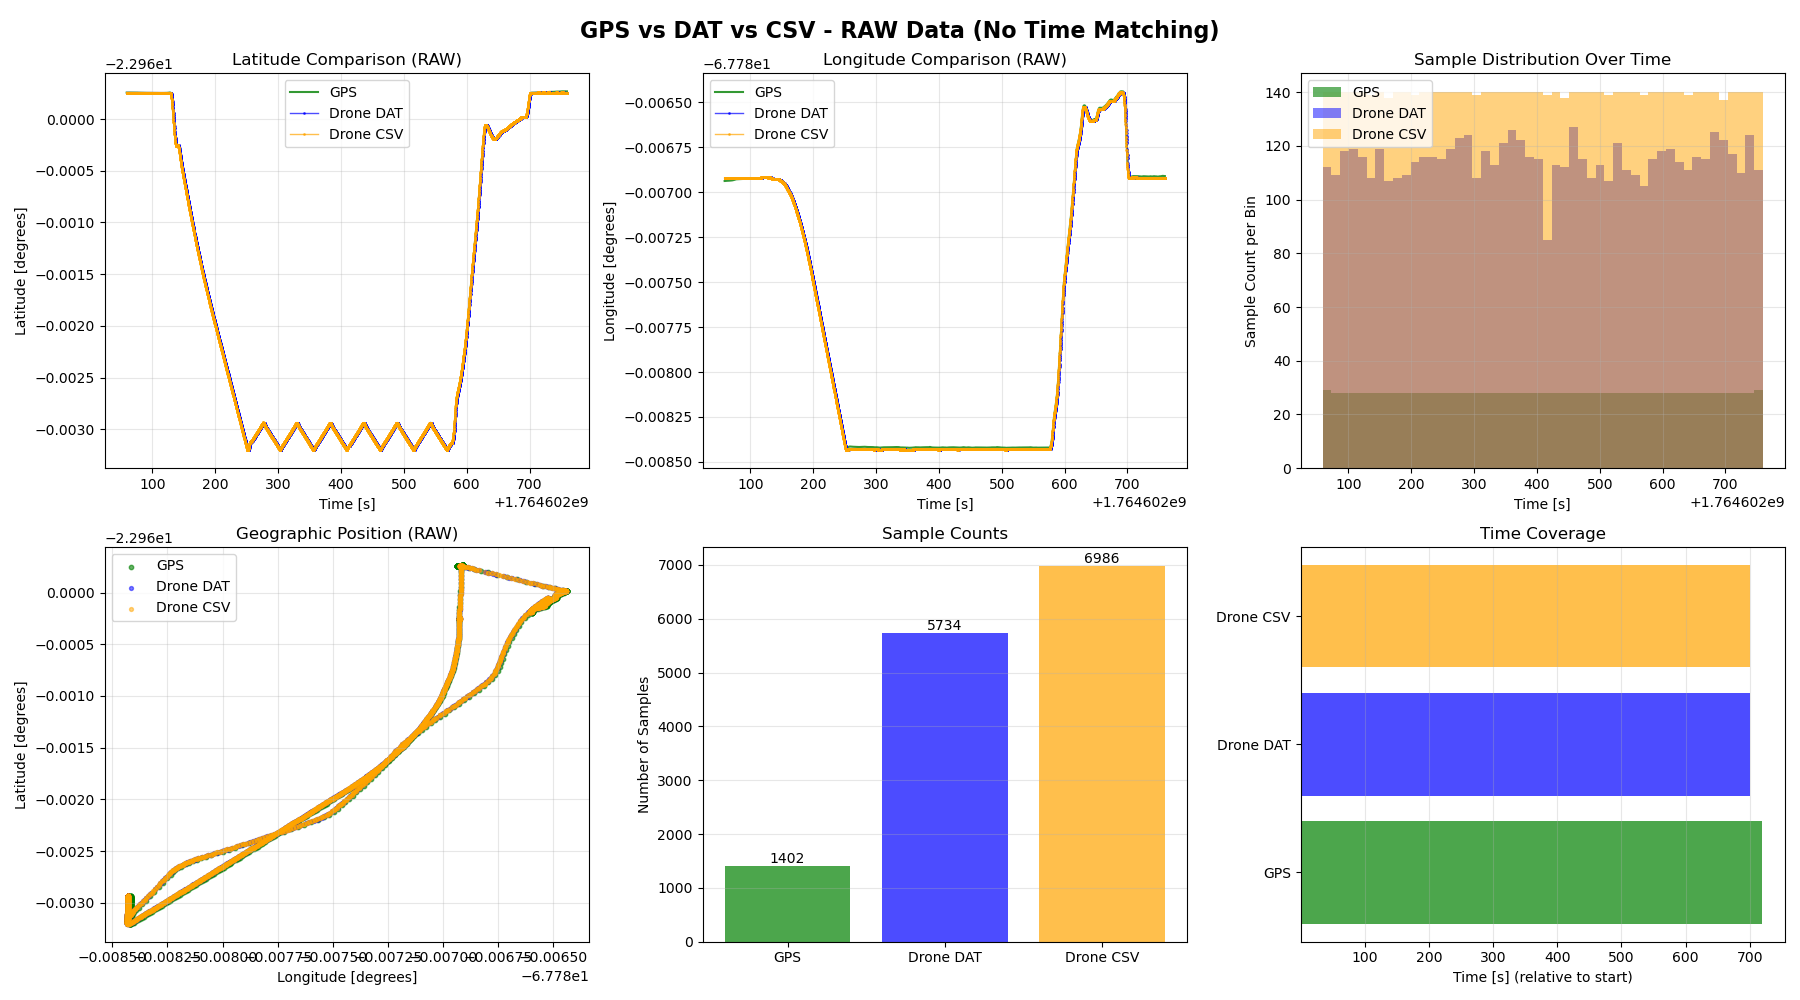

In [531]:
# Generate three-way comparison plot
print("\n" + "="*60)
print("THREE-WAY COMPARISON: GPS vs DAT vs CSV")
print("="*60)
fig = plot_three_way_comparison(gps_df, drone_sources)

In [674]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import importlib

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import polars as pl
from IPython.display import display, Image

# Add paths for imports
sys.path.insert(0, str(Path.cwd()))
sys.path.insert(0, str(Path("/home/stout")))
sys.path.insert(0, str(Path("/home/gabriele/Documents/data_loader")))

# Force complete reload of pils modules
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Import the StoutDataLoader - handles all data loading
from pils.loader import StoutDataLoader

print("✓ All libraries imported successfully")
print(f"✓ Reloaded {len(modules_to_remove)} pils modules")

✓ All libraries imported successfully
✓ Reloaded 23 pils modules


In [659]:
loader = StoutDataLoader(use_stout=True)
# Load GPS and DJI drone data using the generic loader
data = loader.load_flight_data(
    flight_id=FLIGHT_UUID,
    drones=['dji'],
    drone_correct_timestamp=False,
    polars_interpolation=True,
    align_drone=False
)

df_polars = data['dji']



2026-01-20 16:39:42,226 - pils.loader - INFO - Initialized with stout database, base path: /mnt/data/POLOCALC
2026-01-20 16:39:42,226 - pils.loader - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-01-20 16:39:42,227 - pils.loader - INFO - Loaded flight: flight_20251201_1515
2026-01-20 16:39:42,227 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux
2026-01-20 16:39:42,228 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux/sensors/20251201_151517_GPS.bin
2026-01-20 16:39:42,226 - pils.loader - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-01-20 16:39:42,227 - pils.loader - INFO - Loaded flight: flight_20251201_1515
2026-01-20 16:39:42,227 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux
20

In [669]:
from pathlib import Path

modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]

from pils.drones.DJIDrone import DJIDrone

csv_path = Path(CSV_DRONE_FILE)
drone = DJIDrone(CSV_DRONE_FILE)

drone.data = data["dji"]

t, r = drone.get_tick_offset()

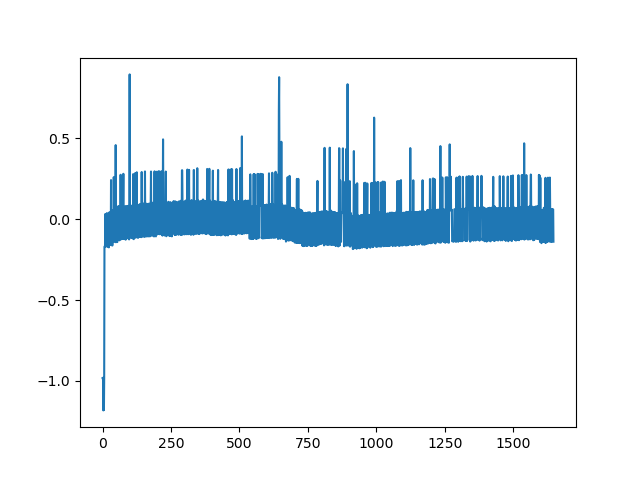

In [670]:
plt.figure()
plt.plot(r)

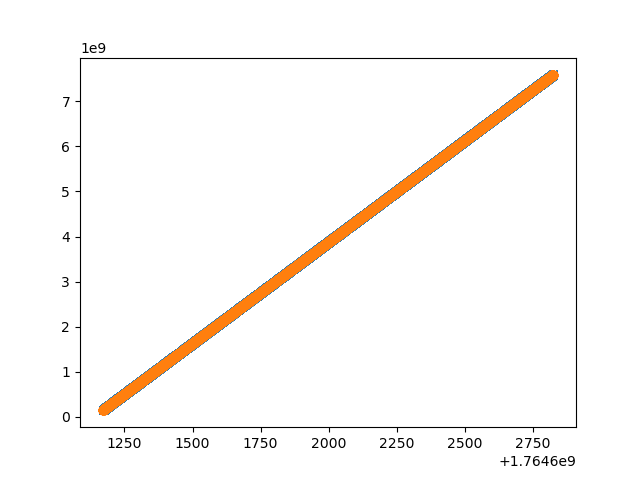

In [671]:
plt.figure()
plt.plot(df_polars['GPS']['timestamp'], df_polars['GPS']['tick'], 'x')
plt.plot(df_polars['GPS']['correct_timestamp'], df_polars['GPS']['correct_tick'], 'o')

In [673]:
df_polars['GPS'][-1].select([
    pl.col("correct_timestamp").map_elements(lambda x: f"{x:.3f}"),
    pl.col("timestamp").map_elements(lambda x: f"{x:.3f}"),
    pl.col("wrong_timestamp").map_elements(lambda x: f"{x:.3f}")
])

correct_timestamp,timestamp,wrong_timestamp
str,str,str
"""1764602824.706""","""1764602825.000""","""1764602826.041"""


In [676]:
gps_only = data['dji']['GPS']

In [687]:

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import polars as pl
from IPython.display import display, Image

# Add paths for imports
sys.path.insert(0, str(Path.cwd()))
sys.path.insert(0, str(Path("/home/stout")))
sys.path.insert(0, str(Path("/home/gabriele/Documents/data_loader")))

# Force complete reload of pils modules
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Import the StoutDataLoader - handles all data loading
from pils.loader import StoutDataLoader

print("✓ All libraries imported successfully")
print(f"✓ Reloaded {len(modules_to_remove)} pils modules")

✓ All libraries imported successfully
✓ Reloaded 23 pils modules


2026-01-20 17:33:28,805 - pils.loader - INFO - Initialized with stout database, base path: /mnt/data/POLOCALC
2026-01-20 17:33:28,806 - pils.loader - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-01-20 17:33:28,807 - pils.loader - INFO - Loaded flight: flight_20251201_1515
2026-01-20 17:33:28,807 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux
2026-01-20 17:33:28,808 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux/sensors/20251201_151517_GPS.bin
2026-01-20 17:33:28,806 - pils.loader - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-01-20 17:33:28,807 - pils.loader - INFO - Loaded flight: flight_20251201_1515
2026-01-20 17:33:28,807 - pils.loader - INFO - Loading gps data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/aux
20

COMPARING INTERPOLATION METHODS: Polars vs Scipy


2026-01-20 17:33:31,431 - pils.loader - INFO - Loaded gps data: (1439, 21)
2026-01-20 17:33:31,432 - pils.loader - INFO - Loading dji data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/drone/20251201_151517_drone.dat
2026-01-20 17:33:31,432 - pils.loader - INFO - Loading dji data from: /mnt/data/POLOCALC/campaigns/202511/20251201/flight_20251201_1515/drone/20251201_151517_drone.dat
2026-01-20 17:33:35,040 - pils.drones.DJIDrone - INFO - Tick unwrap at index 4009: 4,294,296,476 -> 206,394 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-20 17:33:35,041 - pils.drones.DJIDrone - INFO - Loaded 7114 GPS messages from DAT file
2026-01-20 17:33:35,050 - pils.drones.DJIDrone - INFO - Tick unwrap at index 3705: 4,294,110,891 -> 43,735 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-20 17:33:35,040 - pils.drones.DJIDrone - INFO - Tick unwrap at index 4009: 4,294,296,476 -> 206,394 (adding offset 2^32, total offset: 4,294,967,296)
2026-01-20 17:33:35,0

✓ CSV drone data loaded: (15736, 460)


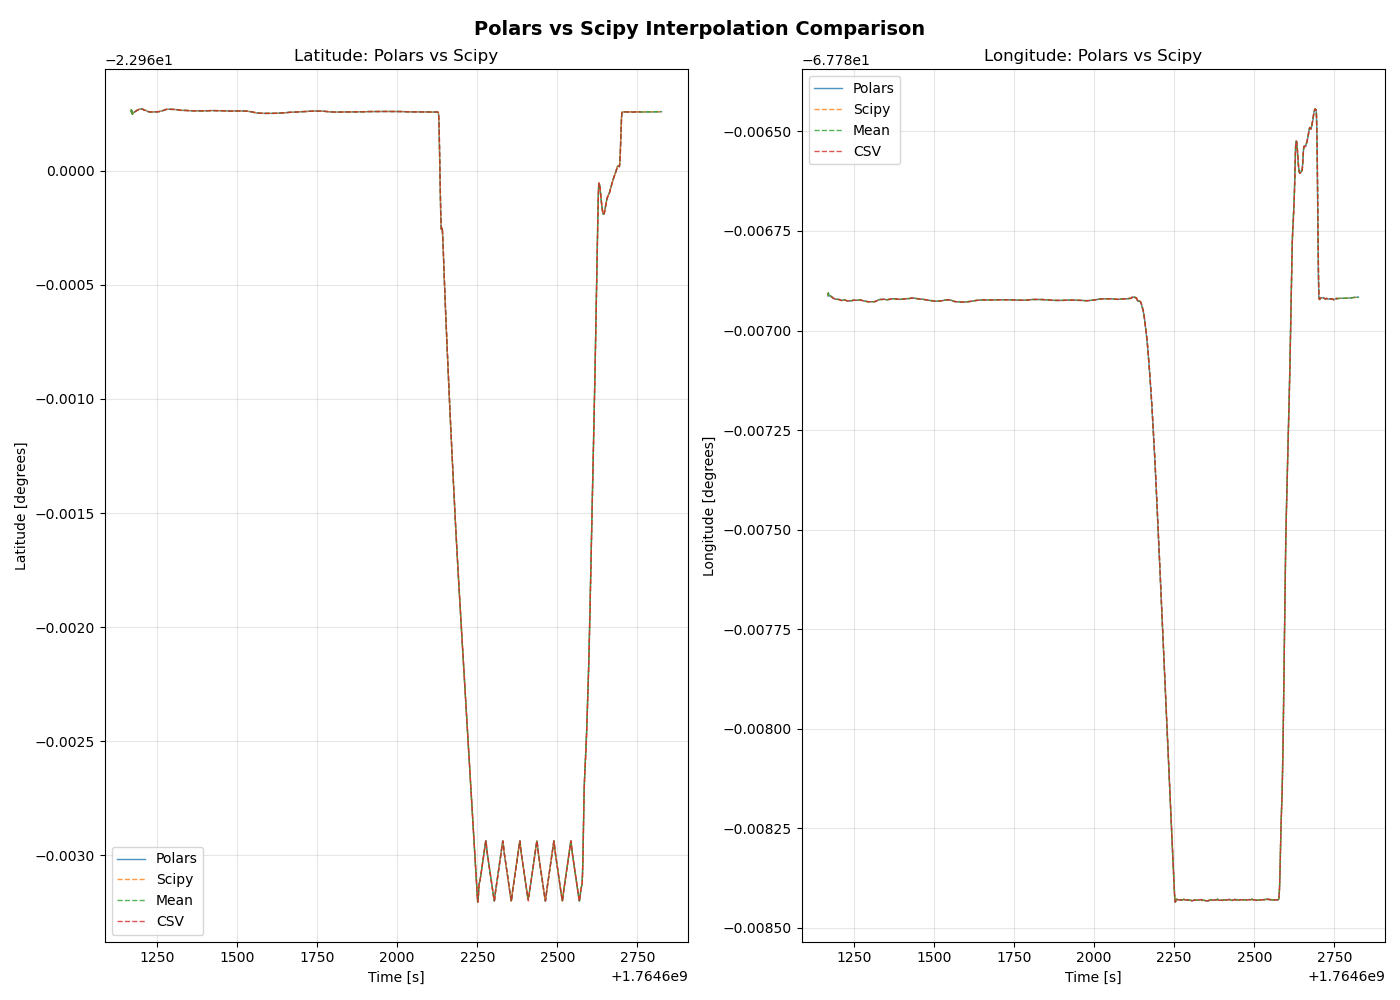

In [688]:
# Compare Polars vs Scipy interpolation methods
print("=" * 80)
print("COMPARING INTERPOLATION METHODS: Polars vs Scipy")
print("=" * 80)

from pils.drones.DJIDrone import DJIDrone
from pathlib import Path

loader = StoutDataLoader(use_stout=True)
# Load GPS and DJI drone data using the generic loader
data = loader.load_flight_data(
    flight_id=FLIGHT_UUID,
    drones=['dji'],
    drone_correct_timestamp=True,
    polars_interpolation=True
)

df_polars = data['dji']

loader = StoutDataLoader(use_stout=True)
data = loader.load_flight_data(
    flight_id=FLIGHT_UUID,
    drones=['dji'],
    drone_correct_timestamp=True,
    polars_interpolation=False
)

df_scipy = data['dji']

loader = StoutDataLoader(use_stout=True)
data = loader.load_flight_data(
    flight_id=FLIGHT_UUID,
    drones=['dji'],
    drone_correct_timestamp=False,
    polars_interpolation=False
)

df_old = data['dji']

from pathlib import Path
from pils.drones.DJIDrone import DJIDrone

csv_path = Path(CSV_DRONE_FILE)
if csv_path.exists():
    # Use DJIDrone class to load CSV file
    drone_csv = DJIDrone(CSV_DRONE_FILE)
    drone_csv.load_data(use_dat=False, cols=None)  # Explicitly use CSV loading
    
    # Extract the CSV data from the dictionary
    if isinstance(drone_csv.data, pl.DataFrame):
        drone_csv_df = drone_csv.data
        print(f"✓ CSV drone data loaded: {drone_csv_df.shape}")
    else:
        drone_csv_df = None
        print("✗ CSV data not found in DJIDrone data dictionary")
else:
    drone_csv_df = None
    print(f"✗ CSV file not found: {CSV_DRONE_FILE}")
# Compare the two
if df_polars is not None and df_scipy is not None and df_old is not None and drone_csv_df is not None:
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))
    fig.suptitle('Polars vs Scipy Interpolation Comparison', fontsize=14, fontweight='bold')
    
    lat_col = "GPS:latitude"
    lon_col = "GPS:longitude"
    
    # Get common time range
    polars_ts = df_polars["correct_timestamp"].to_numpy()
    scipy_ts = df_scipy["correct_timestamp"].to_numpy()
    old_ts = df_old["correct_timestamp"].to_numpy()
    drone_csv_df_ts = drone_csv_df["correct_timestamp"].to_numpy()
    gps_ts = gps_only["timestamp"].to_numpy()

    
    lat_csv = drone_csv_df["GPS:Lat[degrees]"].to_numpy()
    
    # Latitude comparison
    ax = axes[0]
    ax.plot(polars_ts, df_polars[lat_col].to_numpy(), '-', label="Polars", alpha=0.8, linewidth=1)
    ax.plot(scipy_ts, df_scipy[lat_col].to_numpy(), '--', label="Scipy", alpha=0.8, linewidth=1)
    ax.plot(old_ts, df_old[lat_col].to_numpy(), '--', label="Mean", alpha=0.8, linewidth=1)
    ax.plot(drone_csv_df_ts[~np.isnan(lat_csv)],  lat_csv[~np.isnan(lat_csv)], '--', label="CSV", alpha=0.8, linewidth=1)
    # ax.plot(gps_ts,  gps_only[lat_col], '--', label="GPS", alpha=0.8, linewidth=1)
    ax.set_title("Latitude: Polars vs Scipy")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Latitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)
    

    long_csv = drone_csv_df["GPS:Long[degrees]"].to_numpy()
    # Longitude comparison
    ax = axes[1]
    ax.plot(polars_ts, df_polars[lon_col].to_numpy(), '-', label="Polars", alpha=0.8, linewidth=1)
    ax.plot(scipy_ts, df_scipy[lon_col].to_numpy(), '--', label="Scipy", alpha=0.8, linewidth=1)
    ax.plot(old_ts, df_old[lon_col].to_numpy(), '--', label="Mean", alpha=0.8, linewidth=1)
    ax.plot(drone_csv_df_ts[~np.isnan(long_csv)], long_csv[~np.isnan(long_csv)], '--', label="CSV", alpha=0.8, linewidth=1)
    ax.set_title("Longitude: Polars vs Scipy")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Longitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Difference plots - need to align to same timestamps first
    # Use join_asof to match timestamps
    
    plt.tight_layout()
    plt.show()

else:
    print("Could not compare - one or both interpolation methods failed")

In [686]:
df_polars

tick,msg_type,GPS:date,GPS:time,GPS:longitude,GPS:latitude,GPS:heightMSL,GPS:velN,GPS:velE,GPS:velD,GPS:hdop,GPS:pdop,GPS:hacc,GPS:sacc,GPS:numGPS,GPS:numGLN,GPS:numSV,datetime,timestamp,correct_timestamp,RTK:date,RTK:time,RTK:lon_p,RTK:lat_p,RTK:hmsl_p,RTK:lon_s,RTK:lat_s,RTK:hmsl_s,RTK:vel_n,RTK:vel_e,RTK:vel_d,RTK:yaw,RTK:svn_s,RTK:svn_p,RTK:hdop,RTK:pitch,RTK:pos_flg_0,RTK:pos_flg_1,RTK:pos_flg_2,RTK:pos_flg_3,RTK:pos_flg_4,RTK:pos_flg_5,RTK:gps_state
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
90722730,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-32768.0,0.0,0.0,-4.6566e-10,2.5148e-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91712457,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-32768.0,0.0,0.0,-4.6566e-10,2.5148e-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92612599,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-32768.0,0.0,0.0,-4.6566e-10,2.5148e-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93602073,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-32768.0,0.0,0.0,-4.6566e-10,2.5148e-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94322836,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-32768.0,0.0,0.0,-4.6566e-10,2.5148e-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
7595159065,53234,2.0251201e7,152705.0,-67.786916,-22.959741,5149.841737,-0.002634,0.0,0.004731,60.0,122.0,3.0,921.0,9.0,8.0,17.0,null,1.7646e9,1.7646e9,0.0,0.0,-67.786896,-22.959743,5173.966309,-6.7787e8,-2.2960e8,5.140078e6,0.81787,-0.022182,-0.634158,-16606.0,30.0,0.0,2.3910e-39,-3.4360e-20,56.0,64.0,16.0,50.0,50.0,0.0,0.0
7595404940,2096,2.0251201e7,152705.0,-67.786916,-22.959741,5149.842,0.0,0.0,0.01,60.0,122.0,3.0,921.0,9.0,8.0,17.0,"""2025-12-01 15:27:05""",1.7646e9,1.7646e9,0.0,0.0,-67.786896,-22.959743,5173.966042,-6.7787e8,-2.2960e8,5.1401e6,0.490386,-0.0638,-0.703987,-16588.24461,30.0,0.0,2.3910e-39,-595.541278,58.185279,64.0,16.0,50.0,50.0,0.0,0.0
7596059179,53234,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,-67.786896,-22.959743,5173.965332,-6.7787e8,-2.2960e8,5.14008e6,-0.381003,-0.174539,-0.889792,-16541.0,30.0,0.0,2.3910e-39,-2180.193359,64.0,64.0,16.0,50.0,50.0,0.0,0.0


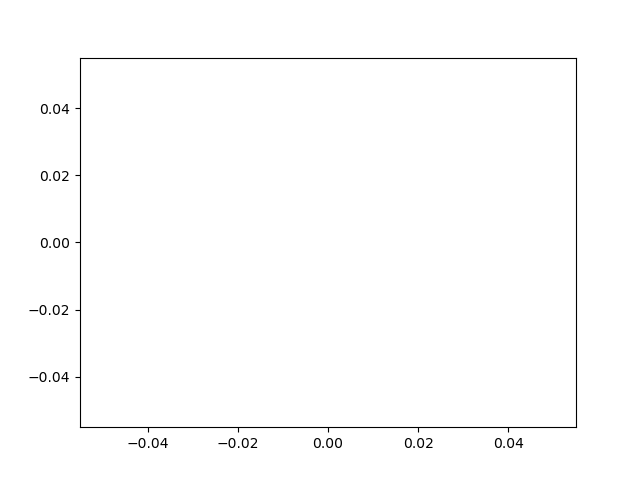

In [682]:
plt.figure()
# plt.plot(df_polars['timestamp'], df_polars[lat_col], 'o')
plt.plot(df_polars['correct_timestamp'], df_polars[lat_col])

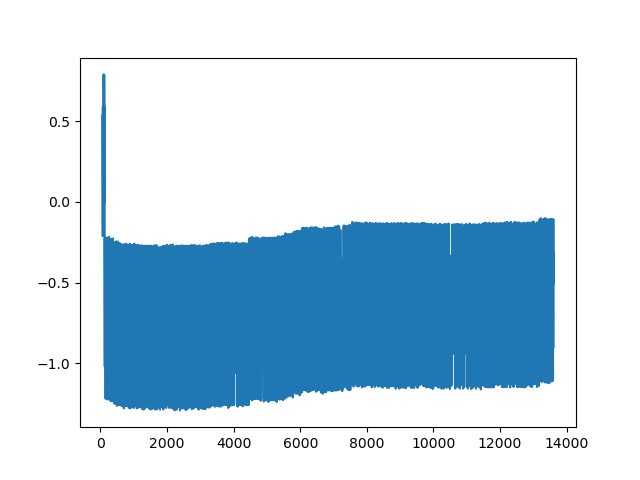

In [633]:
plt.figure()
plt.plot(df_polars['timestamp']-df_polars['correct_timestamp'])

In [639]:
df_polars[2000].select([
    pl.col("correct_timestamp").map_elements(lambda x: f"{x:.3f}"),
    pl.col("timestamp").map_elements(lambda x: f"{x:.3f}")
])

correct_timestamp,timestamp
str,str
"""1764601405.230""","""1764601404.815"""


## Cell 7: Distribution Analysis Histograms

In [ ]:
# Create histograms for error distribution comparison
print("\n" + "="*60)
print("ERROR DISTRIBUTION HISTOGRAMS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('GPS Error Distribution: DAT vs CSV', fontsize=14, fontweight='bold')

colors = {'dat': 'blue', 'csv': 'orange'}

# Latitude error histogram
ax = axes[0]
for source_name, comparison in comparisons.items():
    if "latitude" in comparison:
        # Determine column name based on source type
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
        else:
            lat_col = "GPS:latitude"
        
        # Recreate merged data to get actual differences
        merged = gps_df.join_asof(
            drone_sources[source_name].select(["timestamp", lat_col]),
            on="timestamp",
            strategy="nearest"
        )
        lat_diff = (merged["posllh_lat"].to_numpy() - merged[lat_col].to_numpy()) * 111000
        ax.hist(lat_diff, bins=50, alpha=0.6, label=f'{source_name.upper()}: μ={comparison["latitude"]["mean_diff"]*111000:.2f}m', 
                color=colors.get(source_name, 'red'))

ax.set_xlabel('Latitude Error [m]')
ax.set_ylabel('Frequency')
ax.set_title('Latitude Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Longitude error histogram
ax = axes[1]
for source_name, comparison in comparisons.items():
    if "longitude" in comparison:
        # Determine column name based on source type
        if source_name == 'csv':
            lon_col = "GPS:Long[degrees]"
        else:
            lon_col = "GPS:longitude"
        
        merged = gps_df.join_asof(
            drone_sources[source_name].select(["timestamp", lon_col]),
            on="timestamp",
            strategy="nearest"
        )
        mean_lat = np.mean(merged["posllh_lat"].to_numpy())
        lon_diff = (merged["posllh_lon"].to_numpy() - merged[lon_col].to_numpy()) * 111000 * np.cos(np.radians(mean_lat))
        ax.hist(lon_diff, bins=50, alpha=0.6, label=f'{source_name.upper()}: μ={comparison["longitude"]["mean_diff"]*111000*np.cos(np.radians(mean_lat)):.2f}m', 
                color=colors.get(source_name, 'red'))

ax.set_xlabel('Longitude Error [m]')
ax.set_ylabel('Frequency')
ax.set_title('Longitude Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distance error histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('Geographic Distance Error Distribution', fontsize=14, fontweight='bold')

for source_name, comparison in comparisons.items():
    if "distance_m" in comparison:
        # Determine column names based on source type
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
            lon_col = "GPS:Long[degrees]"
        else:
            lat_col = "GPS:latitude"
            lon_col = "GPS:longitude"
        
        merged = gps_df.join_asof(
            drone_sources[source_name].select(["timestamp", lat_col, lon_col]),
            on="timestamp",
            strategy="nearest"
        )
        
        gps_lats = merged["posllh_lat"].to_numpy()
        gps_lons = merged["posllh_lon"].to_numpy()
        drone_lats = merged[lat_col].to_numpy()
        drone_lons = merged[lon_col].to_numpy()
        
        R = 6371000
        dlat = np.radians(drone_lats - gps_lats)
        dlon = np.radians(drone_lons - gps_lons)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(gps_lats)) * np.cos(np.radians(drone_lats)) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        distances = R * c
        
        ax.hist(distances, bins=50, alpha=0.6, label=f'{source_name.upper()}: μ={comparison["distance_m"]["mean"]:.2f}m, max={comparison["distance_m"]["max"]:.2f}m', 
                color=colors.get(source_name, 'red'))

ax.set_xlabel('Distance Error [m]')
ax.set_ylabel('Frequency')
ax.set_title('Geographic Distance Error')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cell 8: Explore Available Flights in Database

In [ ]:
# List all flights in the database using the loader
all_flights = loader.load_all_campaign_flights()

print(f"Total flights in database: {len(all_flights)}")
print("\nAvailable flights (last 10):")
print("=" * 80)

for i, flight in enumerate(all_flights[-10:], 1):
    takeoff = flight.get('takeoff_datetime', 'N/A')
    flight_id = flight.get('flight_id', 'N/A')
    flight_name = flight.get('flight_name', 'N/A')
    print(f"{i}. {flight_name} | {takeoff}")
    print(f"   ID: {flight_id}\n")

print("=" * 80)
print("To analyze a different flight, modify the FLIGHT_UUID in Cell 3 and re-run from there.")

In [489]:
df1 = pl.DataFrame({"date": [1.1, 2.8, 3.2], "usdeur": [3., 4.3, 8.2], "id": [30, 30, 30], 
                    "GPS:Status": ["OK", "OK", "OK"]})
df3 = pl.DataFrame({"date": [1.5, 5.0], "foobar": [6.2, 7.4], "id": [40, 40], "RTK:Status": ["KO", "KO"]})

# Create empty DataFrame with correct schema (f64 for date column)
t = pl.DataFrame({"date": pl.Series([], dtype=pl.Float64)})

tmp = df1.join(df3, on=['date', 'id'], how='full', coalesce=True).sort('date')

print(tmp)
print(t.join(df3, on=['date'], how='full', coalesce=True).sort('date'))

tmp2 = tmp.interpolate().fill_null(strategy="forward").fill_null(strategy="backward")

print(tmp2)


shape: (5, 6)
┌──────┬────────┬─────┬────────────┬────────┬────────────┐
│ date ┆ usdeur ┆ id  ┆ GPS:Status ┆ foobar ┆ RTK:Status │
│ ---  ┆ ---    ┆ --- ┆ ---        ┆ ---    ┆ ---        │
│ f64  ┆ f64    ┆ i64 ┆ str        ┆ f64    ┆ str        │
╞══════╪════════╪═════╪════════════╪════════╪════════════╡
│ 1.1  ┆ 3.0    ┆ 30  ┆ OK         ┆ null   ┆ null       │
│ 1.5  ┆ null   ┆ 40  ┆ null       ┆ 6.2    ┆ KO         │
│ 2.8  ┆ 4.3    ┆ 30  ┆ OK         ┆ null   ┆ null       │
│ 3.2  ┆ 8.2    ┆ 30  ┆ OK         ┆ null   ┆ null       │
│ 5.0  ┆ null   ┆ 40  ┆ null       ┆ 7.4    ┆ KO         │
└──────┴────────┴─────┴────────────┴────────┴────────────┘
shape: (2, 4)
┌──────┬────────┬─────┬────────────┐
│ date ┆ foobar ┆ id  ┆ RTK:Status │
│ ---  ┆ ---    ┆ --- ┆ ---        │
│ f64  ┆ f64    ┆ i64 ┆ str        │
╞══════╪════════╪═════╪════════════╡
│ 1.5  ┆ 6.2    ┆ 40  ┆ KO         │
│ 5.0  ┆ 7.4    ┆ 40  ┆ KO         │
└──────┴────────┴─────┴────────────┘
shape: (5, 6)
┌──────┬─────

In [465]:
mp_df[0].update(mp_df[1], how='full')


date,usdeur,id
i64,str,i64
1,"""a""",6
2,"""b""",7
3,"""c""",8
4,null,null
5,null,null
